In [14]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import joblib
import time
import requests as re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Užduotis Nr. 1

In [ ]:
# Apsirašom klasę
class Meteo:
    """
    This class is for meteorological data downloading from https://api.meteo.lt/ using
    REST api.
    """
    # Apsirašom veiksmus atliekamus objekto kūrimo metu
    def __init__(self, history_url, forecast_url):
        self.history_url = history_url
        self.forecast_url = forecast_url

    # Sukūriau atskirą funkciją duomenų atsiuntimui, kadangi funkcija vidinė,
    # tai padariau, kad negalima būtų kviesti kaip metodo
    def __retrieve_data(self, url):
        try:
            data = re.get(url=url, timeout=1000)
        except Exception as e:
            print(e)
        else:
            if data.status_code != 200:
                print(f"Failed to retrieve data: code {data.status_code}")
            else:
                data = data.json()
                return data

    # Sukuriam istorinių duomenų siuntimo metodą
    def get_historical_data(self, start_date, end_date):
        """
        This methods downloads historical weather data from selected time period.

        Parameters:
        start_date - start of the period
        end_date - end of the period
        Date format: string 'yyyy-mm-dd'
        """
        start_date = datetime.strptime(start_date, "%Y-%m-%d")
        end_date = datetime.strptime(end_date, "%Y-%m-%d")
        current_date = start_date
        historical_data = []
        while current_date < end_date:
            url = f'{self.history_url}/{current_date.strftime("%Y-%m-%d")}'
            historical_data += self.__retrieve_data(url)["observations"]
            current_date += timedelta(days=1)
            time.sleep(0.5) # sustabdom, kad neviršytume kreipmosi limito
        historical_data = pd.DataFrame(historical_data)
        historical_data = historical_data.set_index("observationTimeUtc", drop=True)
        # Pasiverčiam į Lietuvos laiko juostą
        historical_data.index = (
            pd.to_datetime(historical_data.index)
            .tz_localize("UTC")
            .tz_convert("Europe/Vilnius")
            .tz_localize(None)
        )
        historical_data.index.name = None
        return historical_data

    def get_forecast(self):
        """
        This methods downloads weather forecast
        """
        forecast = self.__retrieve_data(self.forecast_url)
        forecast = pd.DataFrame(forecast["forecastTimestamps"])
        forecast = forecast.set_index("forecastTimeUtc", drop=True)
        forecast.index = (
            pd.to_datetime(forecast.index)
            .tz_localize("UTC")
            .tz_convert("Europe/Vilnius")
            .tz_localize(None)
        )
        forecast.index.name = None
        return forecast

In [ ]:
# Apsirašom reikiamus url ir sukuriam objektą
HISTORY_URL = "https://api.meteo.lt/v1/stations/vilniaus-ams/observations"
FORECAST_URL = "https://api.meteo.lt/v1/places/vilnius/forecasts/long-term"
vilnius = Meteo(HISTORY_URL, FORECAST_URL)

In [ ]:
# Randame dabartinę datą ir datą lygiai prieš metus
current_date = datetime.now() + timedelta(days=1)
start_date = current_date - relativedelta(years=1)

# Pasiverčiam į string. Atrodo dvigubas darbas, nes metode vėl keičiam į datetime, bet jei kviečiant metodą
# norėtume ranka savo datas įrašyti tai būtų patogiau
current_date = current_date.strftime("%Y-%m-%d")
start_date = start_date.strftime("%Y-%m-%d")

# Atsisiunčiame duomenis
observations = vilnius.get_historical_data(start_date, current_date)
forecast = vilnius.get_forecast()

In [15]:
# Užsaugome dėl viso pikto, kad nereikėtų kiekvieną kartą siųstis ir nepasiektume dieninio limito
joblib.dump(observations, 'observations.sav')
joblib.dump(forecast, 'forecast.sav')

['forecast.sav']

Užduotis Nr. 2

In [16]:
# Apskaičiuojame oro temperatūros ir drėgmės vidurkius
observations[['airTemperature', 'relativeHumidity']].mean()

airTemperature       9.192134
relativeHumidity    78.265150
dtype: float64

In [ ]:
# Apskaičiuojame vidutinę dienos (08:00-20:00) oro temperatūrą
over_08 = pd.to_datetime('08:00:00').time() <= observations.index.time
under_20 = pd.to_datetime('20:00:00').time() > observations.index.time
print('Average air temperature during day:', observations['airTemperature'][over_08 & under_20].mean())

Average air temperature during day 10.679273308957955


In [18]:
# Apskaičiuojam vidutinę nakties (20:00-08:00) oro temperatūrą
print('Average air temperature during night:', observations['airTemperature'][~under_20 | ~over_08].mean())

Average air temperature during night: 7.70295194508009


In [20]:
# Skaičiuosime kiek savaitgalių buvo lietingi
# išsifiltruoju atskirai šeštadienius ir sekmadienius
saturdays = observations['conditionCode'][observations.index.weekday == 5]
sundays = observations['conditionCode'][observations.index.weekday == 6]

# Kadangi šeštadienis/sekmadienis skaitosi kaip vienas savaitgalis,
# sekmadienio datas paslenku diena atgal, kad sutaptų su šeštadieniu
sundays.index = sundays.index - timedelta(days=1)

# Prijungiu sekmadienio duomenis prie šeštadienio pagal datą, kad vienoje eilutėje turėtume abiejų dienų sąlygas
weekends = pd.merge(saturdays, sundays, left_index= True, right_index=True, how = 'outer')

# Išsifiltruoju, kur statuse yra paminėtas lietus ir sukuriu naują kintamąjį 'rain_on_weekend' su True reikšmėmis,
# kur vieną arba kitą dieną buvo lietaus
rain_on_saturday = weekends['conditionCode_x'].apply(lambda x: 'rain' in str(x))
rain_on_sunday = weekends['conditionCode_y'].apply(lambda x: 'rain' in str(x))
rain_on_weekend = (rain_on_saturday | rain_on_sunday).to_frame()

# Ištraukiu datas be valandų
rain_on_weekend['day'] = rain_on_weekend.index.date

# Sugrupuoju duomenis pagal datas, ir patikrinu, kuriose grupėse yra bent viena True reikšmė rodanti, kad kažkuriuo metu lijo.
rainy_weekends = rain_on_weekend.groupby('day').agg(list).unstack().apply(lambda x: True in x).sum()
print(f'Lietingų savaitgalių skaičius {rainy_weekends}')

Lietingų savaitgalių skaičius 32


Užduotis Nr. 3

In [23]:
# Apjungiu istorinius duomenis su prognoze
concatenated = pd.concat([observations, forecast], axis = 0)
concatenated = concatenated.loc[~concatenated.index.duplicated(keep='first')] 

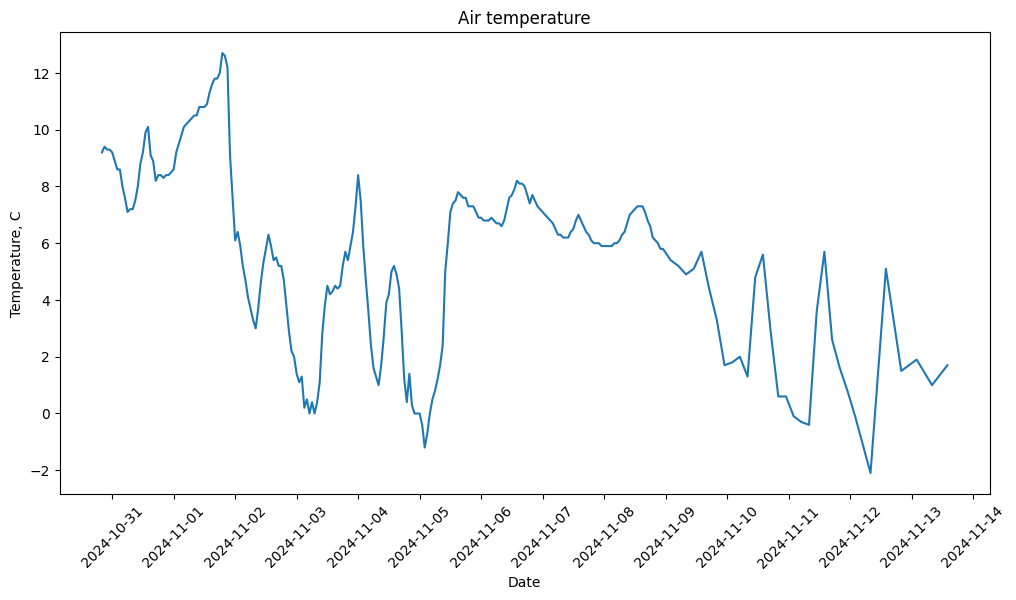

In [24]:
# Apsibrežiame pradžią ir pabaigą, savaitę atgal ir savaitę į priekį
start = datetime.now() - timedelta(days = 7)
end = datetime.now() + timedelta(days = 7)

plt.figure(figsize=(12, 6))
plt.plot(concatenated[start:end]['airTemperature'])
plt.title('Air temperature')
plt.xlabel('Date')
plt.ylabel('Temperature, C')
plt.xticks(rotation = 45)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

Užduotis Nr. 4

In [28]:
# Sukuriu funkciją linijinei interpoliacijai naudojant savo algoritmą
def interpolate(series, interpolation):
    index = series.resample("5min").asfreq().index
    if interpolation == "linear":
        interpolated_series = np.array(series.values[0])[np.newaxis]
        for start, end in zip(series.values[:-1], series.values[1:]):
            interpolated_window = (end - start) / 12 * np.arange(1, 12, 1) + start
            interpolated_series = np.concatenate(
                [interpolated_series, interpolated_window, end[np.newaxis]], axis=0
            )
        return pd.Series(interpolated_series, index=index)

In [29]:
# Sukuriu funkciją interpoliacijai naudojant integruotas pandas interpoliacijas
def interpolate_2(series, interpolation):
    series = series.resample("5min").asfreq().interpolate(method=interpolation)
    return series

In [31]:
inter = interpolate(forecast[:10]['airTemperature'], 'linear')
print(inter[:20])

2024-11-06 19:00:00    7.800000
2024-11-06 19:05:00    7.791667
2024-11-06 19:10:00    7.783333
2024-11-06 19:15:00    7.775000
2024-11-06 19:20:00    7.766667
2024-11-06 19:25:00    7.758333
2024-11-06 19:30:00    7.750000
2024-11-06 19:35:00    7.741667
2024-11-06 19:40:00    7.733333
2024-11-06 19:45:00    7.725000
2024-11-06 19:50:00    7.716667
2024-11-06 19:55:00    7.708333
2024-11-06 20:00:00    7.700000
2024-11-06 20:05:00    7.683333
2024-11-06 20:10:00    7.666667
2024-11-06 20:15:00    7.650000
2024-11-06 20:20:00    7.633333
2024-11-06 20:25:00    7.616667
2024-11-06 20:30:00    7.600000
2024-11-06 20:35:00    7.583333
Freq: 5min, dtype: float64


In [32]:
inter_2 = interpolate_2(forecast[:10]['airTemperature'], 'linear')
print(inter_2[:20])

2024-11-06 19:00:00    7.800000
2024-11-06 19:05:00    7.791667
2024-11-06 19:10:00    7.783333
2024-11-06 19:15:00    7.775000
2024-11-06 19:20:00    7.766667
2024-11-06 19:25:00    7.758333
2024-11-06 19:30:00    7.750000
2024-11-06 19:35:00    7.741667
2024-11-06 19:40:00    7.733333
2024-11-06 19:45:00    7.725000
2024-11-06 19:50:00    7.716667
2024-11-06 19:55:00    7.708333
2024-11-06 20:00:00    7.700000
2024-11-06 20:05:00    7.683333
2024-11-06 20:10:00    7.666667
2024-11-06 20:15:00    7.650000
2024-11-06 20:20:00    7.633333
2024-11-06 20:25:00    7.616667
2024-11-06 20:30:00    7.600000
2024-11-06 20:35:00    7.583333
Freq: 5min, Name: airTemperature, dtype: float64
